In [16]:
import os
os.environ["DEVELOPMENT"] = '1'

from aquacrop import AquaCropModel, Soil, Crop, InitialWaterContent,IrrigationManagement
from aquacrop.utils import prepare_weather, get_filepath
import pandas as pd
import numpy as np

## Soil fertility calibration

In [17]:
Rel=60
RedaCCx=77
CCx=96

wheat = Crop('WheatGDDAQTEST', planting_date='11/01',need_calib=1,RelativeBio=Rel/100,Ksccx_in=RedaCCx/CCx,fcdecline_in=1)

In [18]:
weather_file_path = get_filepath('tunis_climate.txt')

In [19]:
IrrMethod=0
irrMet=IrrigationManagement(irrigation_method=IrrMethod)

In [20]:
model_os = AquaCropModel(
            sim_start_time=f"{1979}/11/01",
            sim_end_time=f"{1985}/05/30",
            weather_df=prepare_weather(weather_file_path),
            soil=Soil(soil_type='SandyLoam'),
            crop=wheat,
            initial_water_content=InitialWaterContent(value=['FC']),
            irrigation_management=irrMet
        )

In [21]:
model_os._initialize()

print(model_os.crop.Ksccx_in*CCx)
print(100-100*model_os.crop.Ksexpf_es[0])
print(100*model_os.crop.fcdecline_es[0])
print(100-100*model_os.crop.Kswp_es[0])

77.0
12.0
0.06477272727272727
54.000000000000036


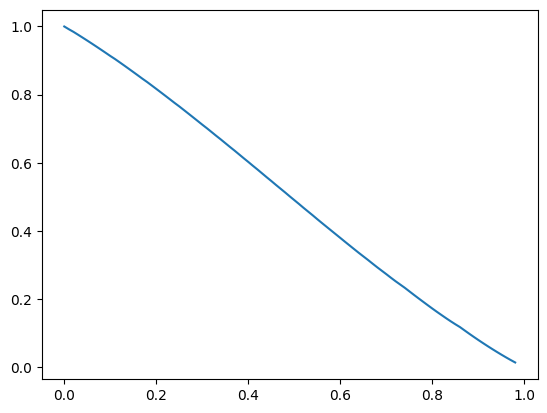

In [22]:
sf_es=model_os.crop.sf_es
Ksexpf_es=model_os.crop.Ksexpf_es
fcdecline_es=model_os.crop.fcdecline_es
Kswp_es=model_os.crop.Kswp_es
Ksccx_es=model_os.crop.Ksccx_es
relbio_es=model_os.crop.relbio_es

import matplotlib.pyplot as plt
plt.plot(sf_es[1:100], relbio_es[1:100])

## run model

In [23]:
stress=57#give the value shown in AquaCrop-windows interface for test
IrrMethod=0
print(sf_es)
print(int(np.argmin(np.abs(sf_es[0:100]-stress/100))))
loc_=np.argmin(np.abs(sf_es[0:100]-stress/100))

Ksccx=Ksccx_es[loc_]
Ksexpf=Ksexpf_es[loc_]
Kswp=Kswp_es[loc_]
fcdecline=fcdecline_es[loc_]

#to compared with the windows-interface
#for very poor soil fertility stress, this value may be adjusted again during initialization
# print(int((1-Ksccx)*100))
# print(int((1-Ksexpf)*100))
# print(int(fcdecline*10000)/100)
# print(int((1-Kswp)*100))

ccx_=(1-Ksccx)*100
cgc_=(1-Ksexpf)*100
dcc_=fcdecline*10000/100
wp_=(1-Kswp)*100

wheat = Crop('WheatGDDAQTEST', planting_date='11/01',Ksccx=1-ccx_/100,Ksexpf=1-cgc_/100,Kswp=1-wp_/100,fcdecline=dcc_/100,\
                 sfertstress=stress/100,sf_es=sf_es,Ksexpf_es=Ksexpf_es,fcdecline_es=fcdecline_es,Kswp_es=Kswp_es,\
                Ksccx_es=Ksccx_es,relbio_es=relbio_es)


irrMet=IrrigationManagement(irrigation_method=IrrMethod)

model_os = AquaCropModel(
            sim_start_time=f"{1979}/11/01",
            sim_end_time=f"{1980}/05/05",
            weather_df=prepare_weather(weather_file_path),
            soil=Soil(soil_type='SandyLoam'),
            crop=wheat,
            initial_water_content=InitialWaterContent(value=['FC']),
            irrigation_management=irrMet
        )


[0.39090242 0.         0.01       0.02       0.03       0.04
 0.05       0.06       0.07       0.08       0.09       0.1
 0.11       0.12       0.13       0.14       0.15       0.16
 0.17       0.18       0.19       0.2        0.21       0.22
 0.23       0.24       0.25       0.26       0.27       0.28
 0.29       0.3        0.31       0.32       0.33       0.34
 0.35       0.36       0.37       0.38       0.39       0.4
 0.41       0.42       0.43       0.44       0.45       0.46
 0.47       0.48       0.49       0.5        0.51       0.52
 0.53       0.54       0.55       0.56       0.57       0.58
 0.59       0.6        0.61       0.62       0.63       0.64
 0.65       0.66       0.67       0.68       0.69       0.7
 0.71       0.72       0.73       0.74       0.75       0.76
 0.77       0.78       0.79       0.8        0.81       0.82
 0.83       0.84       0.85       0.86       0.87       0.88
 0.89       0.9        0.91       0.92       0.93       0.94
 0.95       0.96       0.97

In [24]:
model_os.run_model(till_termination=True)
model_results = model_os.get_crop_growth()

c:\Users\s10034cb\Dropbox (The University of Manchester)\Manchester Postdoc\aquacrop\aquacrop\solution\biomass_accumulation.py:136: RuntimeWarning: invalid value encountered in double_scalars
  BioAdj=FracBiomassPotSF+FracBiomassPotSF-NewCond_B/(Crop.Bio_top[NewCond_DAP]*WPadj)


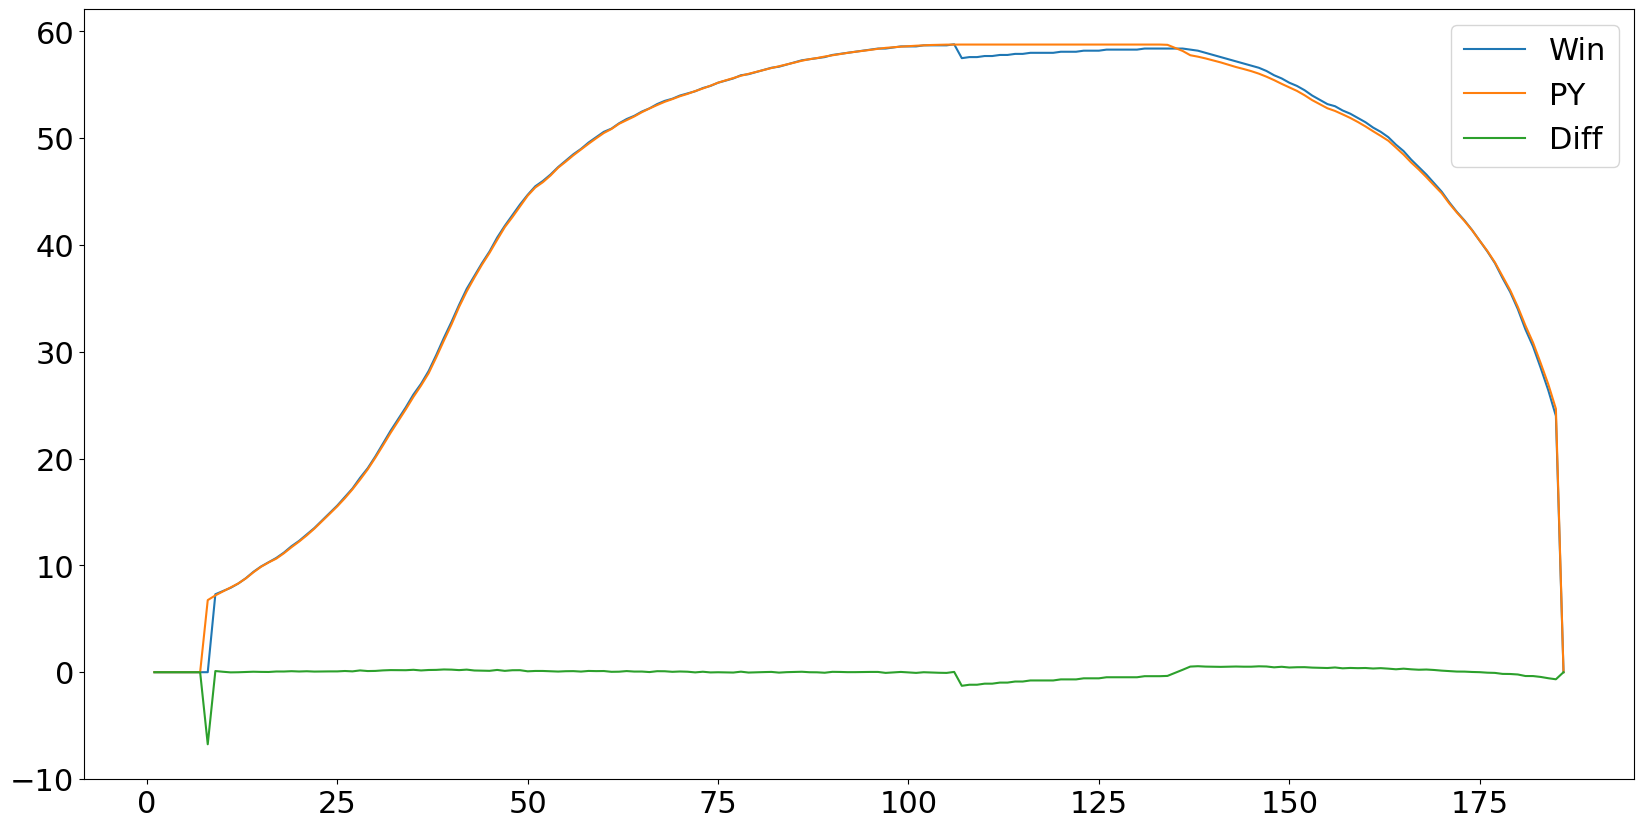

<Figure size 640x480 with 0 Axes>

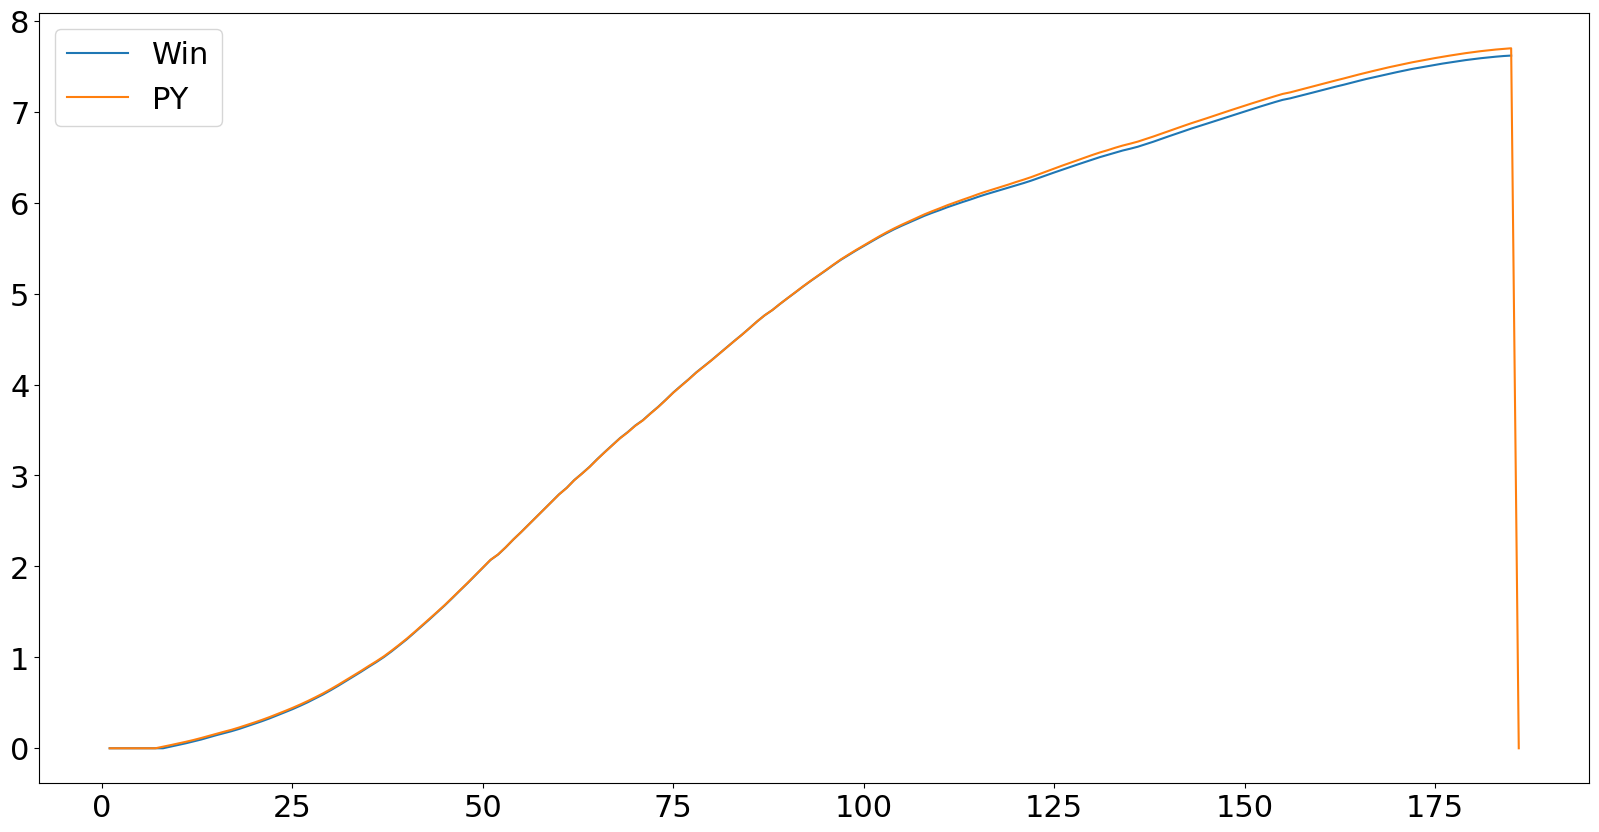

<Figure size 640x480 with 0 Axes>

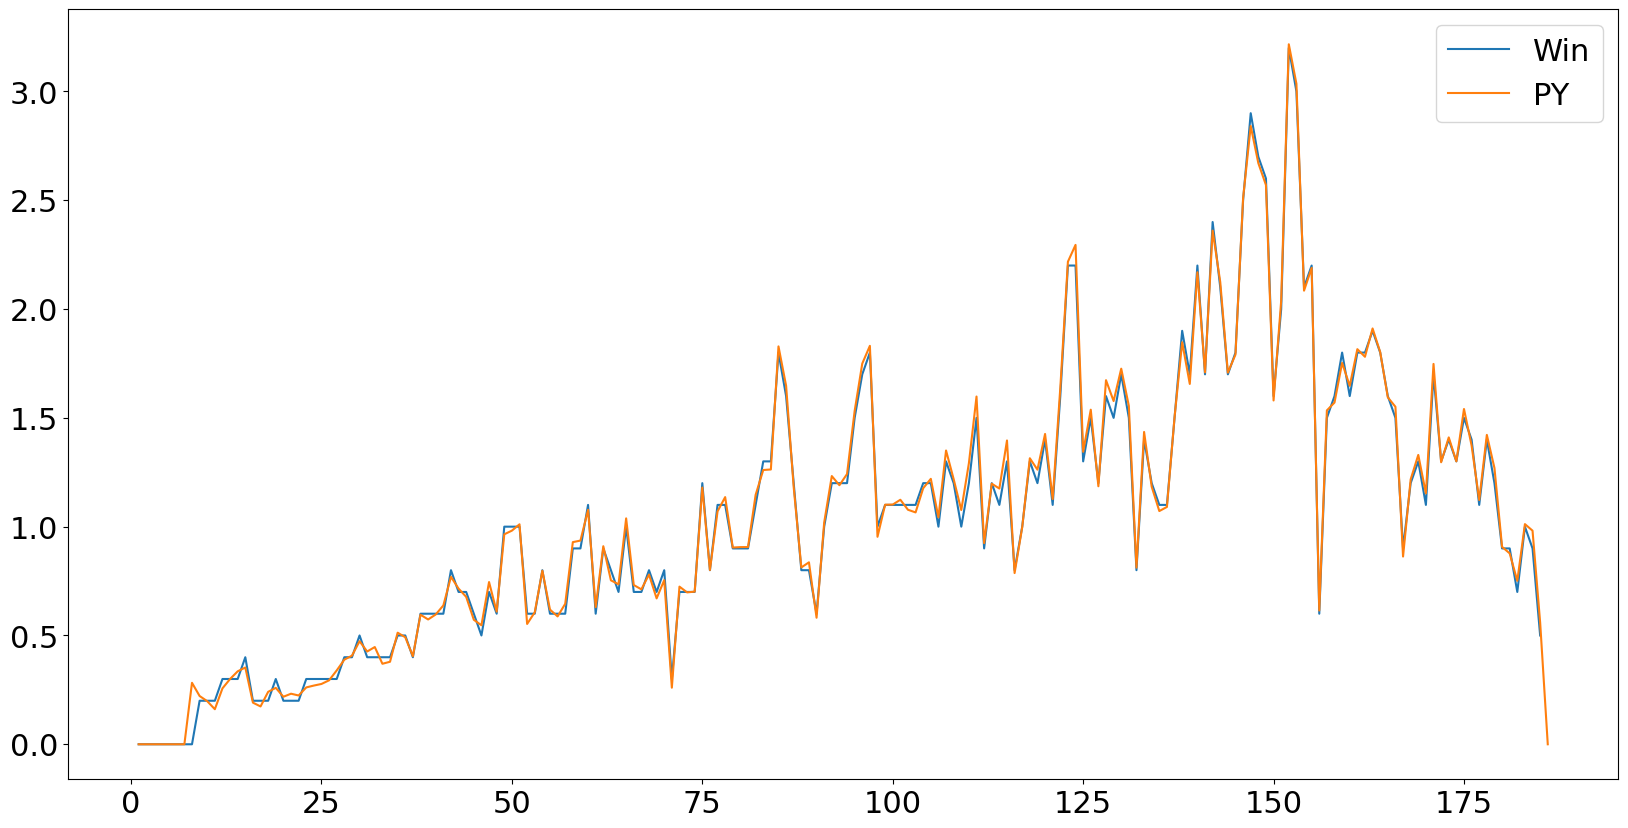

<Figure size 640x480 with 0 Axes>

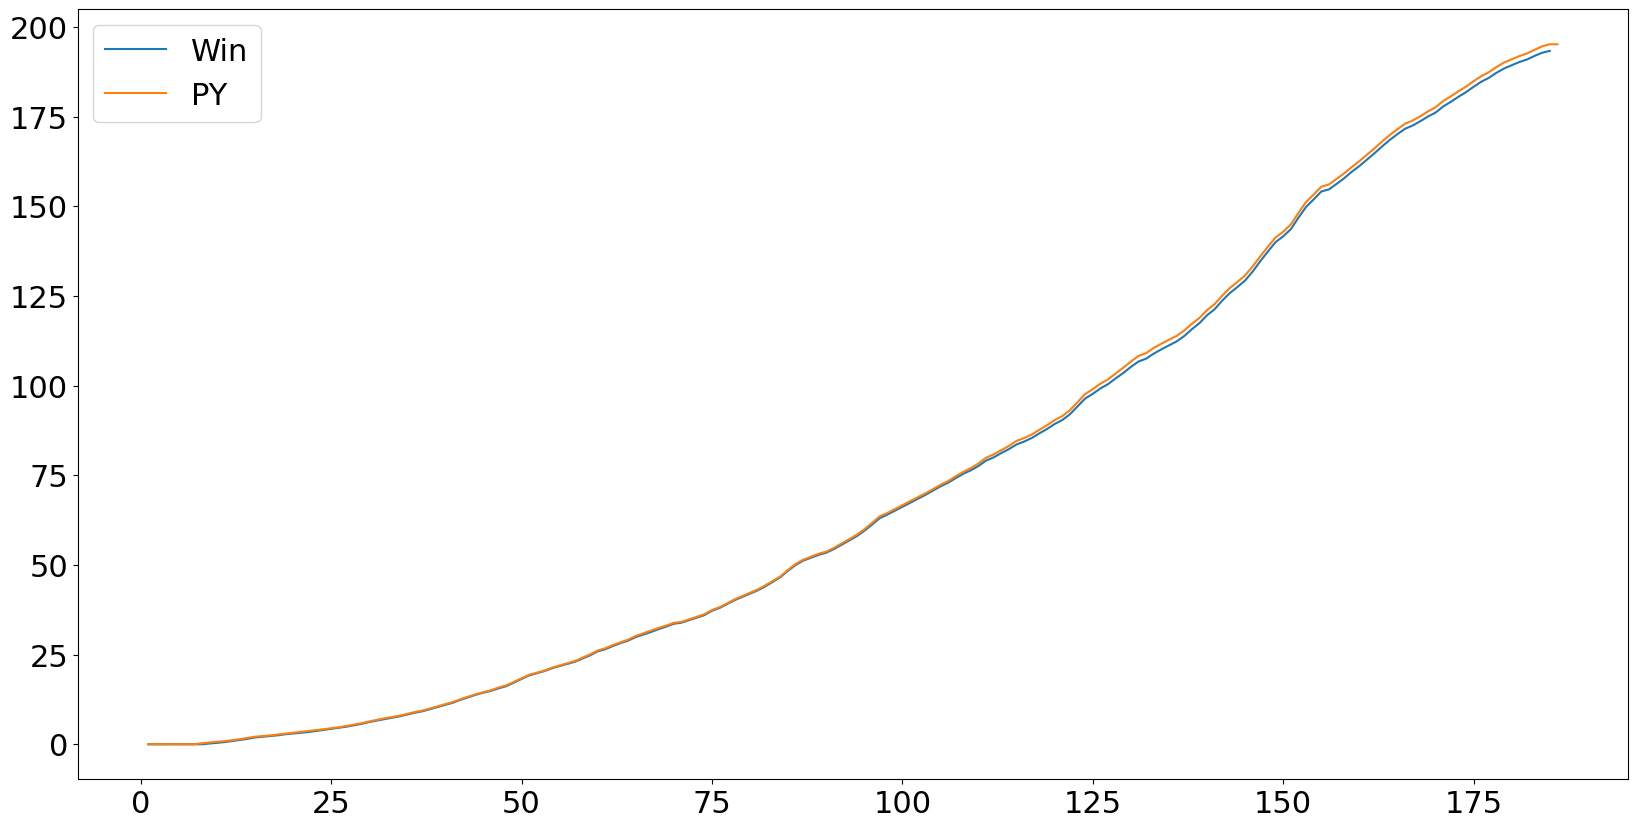

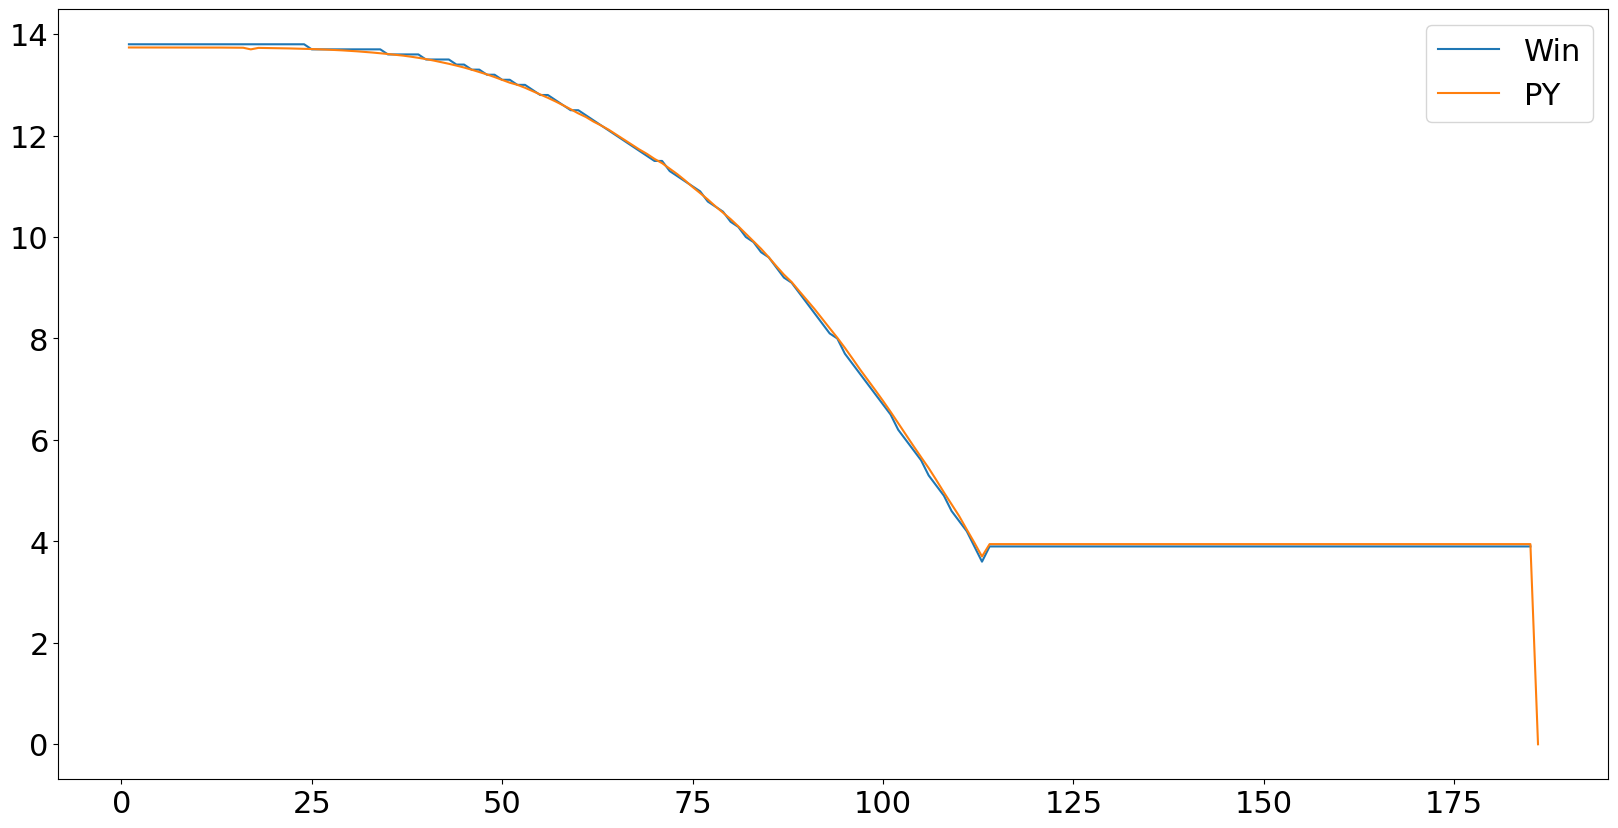

In [27]:
aq=pd.read_table('AquaCropV61Nr02052018\SIMUL\Crop.OUT',skiprows=4, delim_whitespace=True,encoding="latin1")
aq=aq.drop([0])

aq.to_csv('aq_temp.csv')

aq=pd.read_csv('aq_temp.csv')

import matplotlib.pyplot as plt

aq

time=np.array(range(1,len(aq.index)))
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 22})
plt.plot(time,aq.loc[time,'CC'],label='Win')
plt.plot(time,model_results.loc[time,'canopy_cover']*100,label='PY')
plt.plot(time,aq.loc[time,'CC']-model_results.loc[time,'canopy_cover']*100,label='Diff')
plt.legend()
plt.savefig('test_figs\wheat_CCx_irrmethod{0}_stress{1}.png'.format(IrrMethod,stress))
plt.show()

plt.figure()
plt.figure(figsize=(20,10))
plt.plot(time,aq.loc[time,'Biomass'],label='Win')
plt.plot(time,model_results.loc[time,'biomass']/100,label='PY')
plt.legend()
plt.savefig('test_figs\wheat_Biomass_irrmethod{0}_stress{1}.png'.format(IrrMethod,stress))
plt.show()

plt.figure()
plt.figure(figsize=(20,10))
plt.plot(time,aq.loc[time,'Tr'],label='Win')
plt.plot(time,model_results.loc[time,'Tr'],label='PY')
plt.legend()

import itertools
plt.figure()
plt.figure(figsize=(20,10))
plt.plot(time,list(itertools.accumulate(aq.loc[time,'Tr'])),label='Win')
plt.plot(time,list(itertools.accumulate(model_results.loc[time,'Tr'])),label='PY')
plt.legend()
plt.savefig('test_figs\wheat_Traccum_irrmethod{0}_stress{1}.png'.format(IrrMethod,stress))
plt.show()

#time=range(1,175)
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 22})
plt.plot(time,aq.loc[time,'WP'],label='Win')
plt.plot(time,model_results.loc[time,'NewCond.WPadj'],label='PY')
plt.legend()
plt.savefig('test_figs\wheat_WPadj_irrmethod{0}_stress{1}.png'.format(IrrMethod,stress))
plt.show()